In [1]:
from natsort import natsorted
import cv2

import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from natsort import natsorted
#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorboard

l_frames:  ['/space/cba/StirlingDataset/pass5-10/all_frames/Frame1.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame3.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame5.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame7.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame9.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame11.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame13.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame15.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame17.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame19.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame21.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame23.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame25.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame27.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame29.png', '/space/cba/StirlingDataset/pass5-10/all_frames/Frame31.png', '

In [7]:
monkey_colours = ([])
for i in range(300):
    colour = tuple(np.random.randint(255,size = 3))
    monkey_colours.append(colour)

In [8]:
monk = {k:v for k,v in enumerate(monkey_colours)}

[(0, 0, 0), (0, 44, 99), (208, 205, 206), (132, 203, 239), (110, 65, 189), (164, 175, 230), (105, 30, 118), (179, 212, 144), (27, 86, 73), (31, 125, 8), (2, 146, 228), (68, 254, 231), (38, 121, 190), (105, 137, 155), (211, 106, 112), (147, 41, 158), (18, 233, 208), (113, 190, 7), (245, 129, 204), (135, 210, 143), (100, 103, 113), (108, 144, 181), (109, 206, 231), (158, 5, 80), (190, 58, 27), (91, 95, 214), (154, 99, 158), (172, 107, 245), (74, 44, 171), (235, 228, 201), (179, 1, 218), (209, 10, 87), (121, 132, 10), (5, 237, 142), (208, 127, 45), (193, 171, 67), (14, 117, 144), (177, 43, 13), (137, 233, 220), (24, 55, 9), (160, 226, 93), (234, 105, 78), (163, 223, 137), (154, 218, 182), (71, 163, 163), (181, 95, 7), (120, 155, 148), (251, 93, 254), (214, 182, 79), (62, 133, 125), (195, 110, 143), (7, 51, 152), (132, 221, 72), (159, 223, 225), (51, 152, 74), (109, 156, 76), (202, 68, 50), (131, 98, 135), (34, 143, 212), (157, 187, 59), (118, 86, 106), (53, 6, 155), (48, 92, 254), (137, 2

{0: (0, 0, 0),
 1: (0, 44, 99),
 2: (208, 205, 206),
 3: (132, 203, 239),
 4: (110, 65, 189),
 5: (164, 175, 230),
 6: (105, 30, 118),
 7: (179, 212, 144),
 8: (27, 86, 73),
 9: (31, 125, 8),
 10: (2, 146, 228),
 11: (68, 254, 231),
 12: (38, 121, 190),
 13: (105, 137, 155),
 14: (211, 106, 112),
 15: (147, 41, 158),
 16: (18, 233, 208),
 17: (113, 190, 7),
 18: (245, 129, 204),
 19: (135, 210, 143),
 20: (100, 103, 113),
 21: (108, 144, 181),
 22: (109, 206, 231),
 23: (158, 5, 80),
 24: (190, 58, 27),
 25: (91, 95, 214),
 26: (154, 99, 158),
 27: (172, 107, 245),
 28: (74, 44, 171),
 29: (235, 228, 201),
 30: (179, 1, 218),
 31: (209, 10, 87),
 32: (121, 132, 10),
 33: (5, 237, 142),
 34: (208, 127, 45),
 35: (193, 171, 67),
 36: (14, 117, 144),
 37: (177, 43, 13),
 38: (137, 233, 220),
 39: (24, 55, 9),
 40: (160, 226, 93),
 41: (234, 105, 78),
 42: (163, 223, 137),
 43: (154, 218, 182),
 44: (71, 163, 163),
 45: (181, 95, 7),
 46: (120, 155, 148),
 47: (251, 93, 254),
 48: (214, 18

In [14]:
seq_colours = []
for i in range(300):
    a = i
    b = i
    c = i
    col = tuple((a,b,c))
    seq_colours.append(col)

In [15]:
sequential_cols = {k:v for k,v in enumerate(seq_colours)}

In [17]:

def rgb_to_onehot(rgb_image, colormap = sequential_cols):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    #print(rgb_image.shape)
    num_classes = len(colormap)
    colors = np.unique(rgb_image)
    #print(colors)
    colors = {k:v for k,v in enumerate(colors)}
    #print(colors)
    shape = rgb_image.shape[:2]+(num_classes,)
    #print(shape)
    #colors = {k:v for k,v in enumerate(np.unique(rgb_image))}
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        #print('i is: ', i)
        #print('cls is: ', cls)
        #encoded_image[:,:,i] = np.where(rgb_image==colormap[i],encoded_image[:,:,i],colormap[cls]).reshape(shape[:2])
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
        #print(rgb_image.shape)
        #encoded_image[:,:,i] = np.argmax(encoded_image[:,:,i])
        #encoded_image[:,:,i] = np.where(encoded_image[:,:,i]== 1,encoded_image[:,:,i],255)
        #encoded_image = 1-encoded_image
    return encoded_image.astype(np.uint8)


def onehot_to_rgb(onehot, colormap = monk):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    
    single_layer = np.argmax(onehot, axis=2)
    #print(single_layer)
    output = np.zeros(onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        #print(k)
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [19]:
frame_train_args = dict(rescale = 1./255)
mask_train_args = dict()
zbuff_train_args = dict(rescale = 1./255)
l_train_gen = ImageDataGenerator(**frame_train_args)
r_train_gen = ImageDataGenerator(**frame_train_args)
zbuff_train_gen = ImageDataGenerator(**zbuff_train_args)
target_train_gen = ImageDataGenerator(**mask_train_args)



In [68]:
def StereoDepthGenNovel(batch_size = 8, seed = 22, target_size = (224,224)):  ## Two Inputs, two outputs

      data_path = 'GeneratorData/'
        
      left_gen = l_train_gen.flow_from_directory('MonkaaImages/Images/left/',batch_size = batch_size,
                                           target_size = target_size, shuffle = True,
                                           seed = 5)
  
      right_gen = r_train_gen.flow_from_directory('MonkaaImages/Images/right/', batch_size= batch_size,
                                            target_size = target_size, shuffle = True,
                                            seed = 5)
      depth_gen = zbuff_train_gen.flow_from_directory('MonkaaImages/Depth/left/', batch_size = batch_size,
                                                     target_size = target_size, shuffle = True, color_mode = 'grayscale',
                                                     seed = 5)
    
  
      left_mask = target_train_gen.flow_from_directory('MonkaaImages/Object_index/left/', batch_size = batch_size,
                                                  target_size = target_size, shuffle = True,
                                                  seed = 5)
  
      right_mask = target_train_gen.flow_from_directory('MonkaaImages/Object_index/right/', batch_size = batch_size,
                                                  target_size = target_size, shuffle = True,
                                                  seed = 5)
  
      while True:
        left = left_gen.next()
        right = right_gen.next()
        depth= depth_gen.next()
        left_target = left_mask.next()
        right_target = right_mask.next()
        #left = [noisy(left[0][x,:,:,:]) for x in range(left[0].shape[0])]
        #right = [noisy(right[0][x,:,:,:]) for x in range(right[0].shape[0])]
        l_mask = [rgb_to_onehot(left_target[0][x,:,:,:]) for x in range(left_target[0].shape[0])]
        r_mask = [rgb_to_onehot(right_target[0][x,:,:,:]) for x in range(right_target[0].shape[0])]

        yield [np.asarray(left[0]),np.asarray(right[0])], [np.asarray(l_mask),np.asarray(r_mask),np.asarray(depth[0])]


In [27]:

# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [28]:
def stereoDepthNet():   
        with tf.name_scope('layer'):
            n_filters =16
            left_in = Input(shape = (224,224,3),name = 'left_in')
            right_in = Input(shape = (224,224,3),name = 'right_in')

            l_conv1 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'left_conv1')(left_in)
            l_conv1 = BatchNormalization()(l_conv1)
            l_conv2 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(l_conv1)
            l_conv2 = BatchNormalization()(l_conv2)
            l_pool1 = MaxPooling2D(pool_size = (2,2),padding = 'same')(l_conv2)

            l_conv3 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(l_pool1)
            l_conv3 = BatchNormalization()(l_conv1)
            l_conv4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(l_conv3)
            l_conv4 = BatchNormalization()(l_conv2)
            l_pool2 = MaxPooling2D(pool_size = (2,2),padding = 'same')(l_conv4)

            l_conv5 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(l_pool2)
            l_conv5 = BatchNormalization()(l_conv5)
            l_conv6 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(l_conv5)
            l_conv6 = BatchNormalization()(l_conv6)
            l_pool3 = MaxPooling2D(pool_size = (2,2),padding = 'same')(l_conv6)

            l_conv7 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(l_pool3)
            l_conv7 = BatchNormalization()(l_conv7)
            l_conv8 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(l_conv7)
            l_conv8 = BatchNormalization()(l_conv8)
            l_pool4 = MaxPooling2D(pool_size = (2,2),padding = 'same')(l_conv8)

            l_conv9 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(l_pool4)
            l_conv9 = BatchNormalization()(l_conv9)
            l_conv10 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(l_conv9)
            l_conv10 = BatchNormalization()(l_conv10)


            r_conv1 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'right_conv1')(right_in)
            r_conv1 = BatchNormalization()(r_conv1)
            r_conv2 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(r_conv1)
            r_conv2 = BatchNormalization()(r_conv2)
            r_pool1 = MaxPooling2D(pool_size = (2,2),padding = 'same')(r_conv2)

            r_conv3 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(r_pool1)
            r_conv3 = BatchNormalization()(r_conv1)
            r_conv4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(r_conv3)
            r_conv4 = BatchNormalization()(r_conv4)
            r_pool2 = MaxPooling2D(pool_size = (2,2),padding = 'same')(r_conv4)

            r_conv5 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(r_pool2)
            r_conv5 = BatchNormalization()(r_conv5)
            r_conv6 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(r_conv5)
            r_conv6 = BatchNormalization()(r_conv6)
            r_pool3 = MaxPooling2D(pool_size = (2,2),padding = 'same')(r_conv6)

            r_conv7 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(r_pool3)
            r_conv7 = BatchNormalization()(r_conv7)
            r_conv8 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(r_conv7)
            r_conv8 = BatchNormalization()(r_conv8)
            r_pool4 = MaxPooling2D(pool_size = (2,2),padding = 'same')(r_conv8)

            r_conv9 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(r_pool4)
            r_conv9 = BatchNormalization()(r_conv9)
            r_conv10 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(r_conv9)
            r_conv10 = BatchNormalization()(r_conv10)



            merge = concatenate([l_conv10,r_conv10],name = 'merge')  

            l_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(merge)
            l_out1 = BatchNormalization()(l_out1)
            l_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(l_out1)
            l_out1 = BatchNormalization()(l_out1)

            l_up1 = concatenate([UpSampling2D(size=(2, 2))(l_out1), l_conv8], axis=3)

            l_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(l_up1)
            l_out2 = BatchNormalization()(l_out2)
            l_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(l_out2)
            l_out2 = BatchNormalization()(l_out2)

            l_up2 = concatenate([UpSampling2D(size=(2, 2))(l_out2), l_conv6], axis=3)

            l_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(l_up2)
            l_out3 = BatchNormalization()(l_out3)
            l_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(l_out3)
            l_out3 = BatchNormalization()(l_out3)

            l_up3 = concatenate([UpSampling2D(size=(2, 2))(l_out3), l_conv4], axis=3)

            l_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(l_up3)
            l_out4 = BatchNormalization()(l_out4)
            l_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(l_out4)
            l_out4 = BatchNormalization()(l_out4)

            #l_up5 = concatenate([UpSampling2D(size=(2, 2))(l_out4), l_conv6], axis=3)

            l_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(l_out4)
            l_out5 = BatchNormalization()(l_out5)
            l_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(l_out5)
            l_out5 = BatchNormalization()(l_out5)

            l_out = Conv2D(300,(1,1),activation = 'softmax',padding = 'same',name = 'left_output')(l_out5)


            r_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(merge)
            r_out1 = BatchNormalization()(r_out1)
            r_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same')(r_out1)
            r_out1 = BatchNormalization()(r_out1)

            r_up1 = concatenate([UpSampling2D(size=(2, 2))(r_out1), r_conv8], axis=3)

            r_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(r_up1)
            r_out2 = BatchNormalization()(r_out2)
            r_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same')(r_out2)
            r_out2 = BatchNormalization()(r_out2)

            r_up2 = concatenate([UpSampling2D(size=(2, 2))(r_out2), r_conv6], axis=3)

            r_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(r_up2)
            r_out3 = BatchNormalization()(r_out3)
            r_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same')(r_out3)
            r_out3 = BatchNormalization()(r_out3)

            r_up3 = concatenate([UpSampling2D(size=(2, 2))(r_out3), r_conv4], axis=3)

            r_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(r_up3)
            r_out4 = BatchNormalization()(r_out4)
            r_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same')(r_out4)
            r_out4 = BatchNormalization()(r_out4)

            #r_up5 = concatenate([UpSampling2D(size=(2, 2))(r_out4), r_pool1], axis=3)

            r_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(r_out4)
            r_out5 = BatchNormalization()(r_out5)
            r_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same')(r_out5)
            r_out5 = BatchNormalization()(r_out5)

            r_out = Conv2D(300,(1,1),activation = 'softmax',padding = 'same',name = 'right_output')(r_out5)


            d_conv1 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'start_of_depth_branch')(merge)
            d_conv1 = BatchNormalization()(d_conv1)
            d_conv2 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'depth1')(d_conv1)
            d_conv2 = BatchNormalization()(d_conv2)
            #d_conv2 = UpSampling2D(size=(2, 2))(d_conv2)
            #d_pool1 = MaxPooling2D(pool_size = (2,2),padding = 'same')(d_conv2)

            #d_up1 = concatenate([UpSampling2D(size=(2, 2))(d_out1), d_conv8], axis=3)

            d_conv3 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same',name = 'depth2')(d_conv2)
            d_conv3 = BatchNormalization()(d_conv3)
            d_conv4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same',name = 'depth3')(d_conv3)
            d_conv4 = BatchNormalization()(d_conv4)
            #d_conv4 = UpSampling2D(size=(2, 2))(d_conv4)
            d_pool2 = MaxPooling2D(pool_size = (2,2),padding = 'same',name = 'depth_pool_1')(d_conv4)

            d_conv5 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same',name= 'depth4')(d_pool2)
            d_conv5 = BatchNormalization()(d_conv5)
            d_conv6 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same',name = 'depth5')(d_conv5)
            d_conv6 = BatchNormalization()(d_conv6)
            # d_conv6 = UpSampling2D(size=(2, 2))(d_conv6)
            #d_pool3 = MaxPooling2D(pool_size = (2,2),padding = 'same')(d_conv6)

            d_conv7 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same',name = 'depth6')(d_conv6)
            d_conv7 = BatchNormalization()(d_conv7)
            d_conv8 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same',name = 'depth7')(d_conv7)
            d_conv8 = BatchNormalization()(d_conv8)
            #d_conv8 = UpSampling2D(size=(2, 2))(d_conv8)
            d_pool4 = MaxPooling2D(pool_size = (2,2),padding = 'same',name = 'depth_pool_2')(d_conv8)

            d_conv9 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same',name = 'depth8')(d_pool4)
            d_conv9 = BatchNormalization()(d_conv9)
            d_conv10 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same',name = 'depth9')(d_conv9)
            #d_conv10 = UpSampling2D(size=(2, 2))(d_conv10)
            d_conv10 = BatchNormalization()(d_conv10)
            d_conv10 = UpSampling2D(size = (2,2))(d_conv10)

            #d_out = Conv2D(3,(1,1),activation = 'linear',padding='same')(d_conv10)

            d_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_1')(d_conv10)
            d_out1 = BatchNormalization()(d_out1)
            d_out1 = Conv2D(n_filters * 16,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_2')(d_out1)
            d_out1 = BatchNormalization()(d_out1)

            d_up1 = UpSampling2D(size = (2,2))(d_out1)

            d_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_3')(d_out1)
            d_out2 = BatchNormalization()(d_out2)
            d_out2 = Conv2D(n_filters * 8,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_4')(d_out2)
            d_out2 = BatchNormalization()(d_out2)

            d_up2 =  concatenate([UpSampling2D(size=(2, 2))(d_out2), l_conv10,r_conv10], axis=3,name = 'first_depth_concat')

            d_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_5')(d_up2)
            d_out3 = BatchNormalization()(d_out3)
            d_out3 = Conv2D(n_filters * 4,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_6')(d_out3)
            d_out3 = BatchNormalization()(d_out3)

            d_up3 = concatenate([UpSampling2D(size=(2, 2))(d_out3), l_conv8,r_conv8], axis=3,name = 'second_depth_concat')

            d_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_7')(d_up3)
            d_out4 = BatchNormalization()(d_out4)
            d_out4 = Conv2D(n_filters * 2,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_8')(d_out4)
            d_out4 = BatchNormalization()(d_out4)

            d_up4 = concatenate([UpSampling2D(size=(2, 2))(d_out4), l_conv6,r_conv6], axis=3,name = 'third_depth_concat')

            d_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_9')(d_up4)
            d_out5 = BatchNormalization()(d_out5)
            d_out5 = Conv2D(n_filters * 1,(3,3),activation = 'relu',padding = 'same',name = 'depth_out_10')(d_out5)
            d_out5 = BatchNormalization()(d_out5)

            d_up5 = UpSampling2D(size=(2, 2))(d_out5)


            d_out = Conv2D(1,(1,1),activation = 'linear',padding = 'same',name = 'depth_output')(d_up5)

            model = Model(inputs = [left_in,right_in],outputs = [l_out,r_out,d_out])

            return model



In [30]:
model = stereoDepthNet()

In [31]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_in (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
right_in (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
left_conv1 (Conv2D)             (None, 224, 224, 16) 448         left_in[0][0]                    
__________________________________________________________________________________________________
right_conv1 (Conv2D)            (None, 224, 224, 16) 448         right_in[0][0]                   
_______________________________________________________________________________________

In [33]:
model.load_weights('FreshMonkaaWeights.h5')

In [34]:
model.compile(optimizer = 'adam',loss = ['categorical_crossentropy','categorical_crossentropy','MAE'],metrics = ['accuracy',dice_coef,dice_coef_loss])

In [69]:
testing_gen = StereoDepthGenNovel()
[left_img,right_img],[mask,mask2,depth] = next(testing_gen)
#pred_all= model.predict([left_img,right_img])
#score = model.evaluate(x = [left_img,right_img],y = [mask,mask2,depth],verbose = 1,return_dict = True)
#np.shape(pred_all)
#print(np.shape(pred_all[0]))

Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [ ]:
pred_all =  model.predict([left_img[0:40],right_img[0:40]])

IndexError: index 8 is out of bounds for axis 0 with size 8

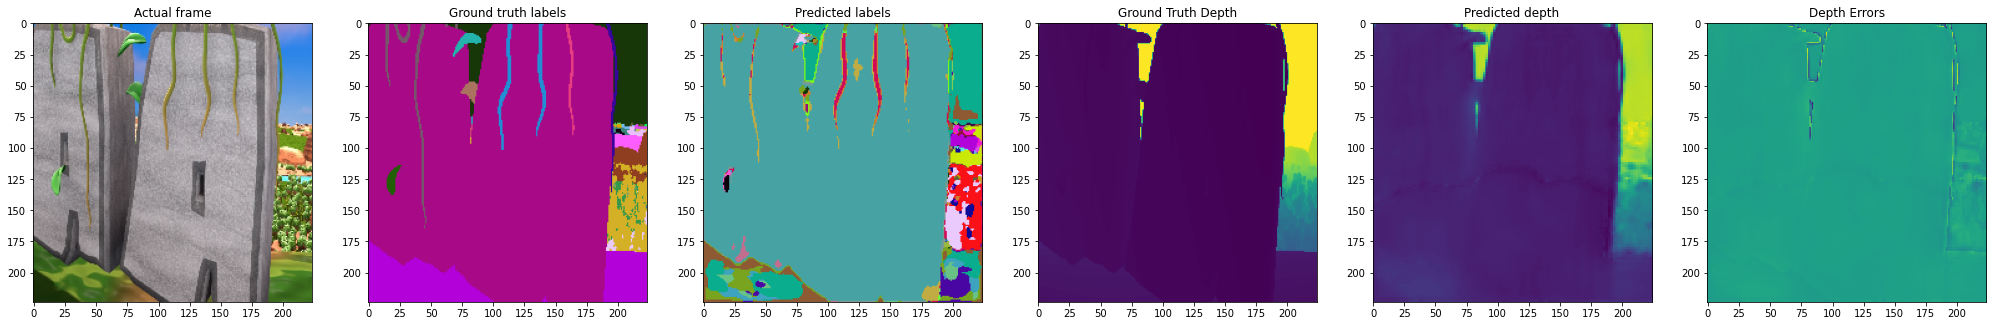

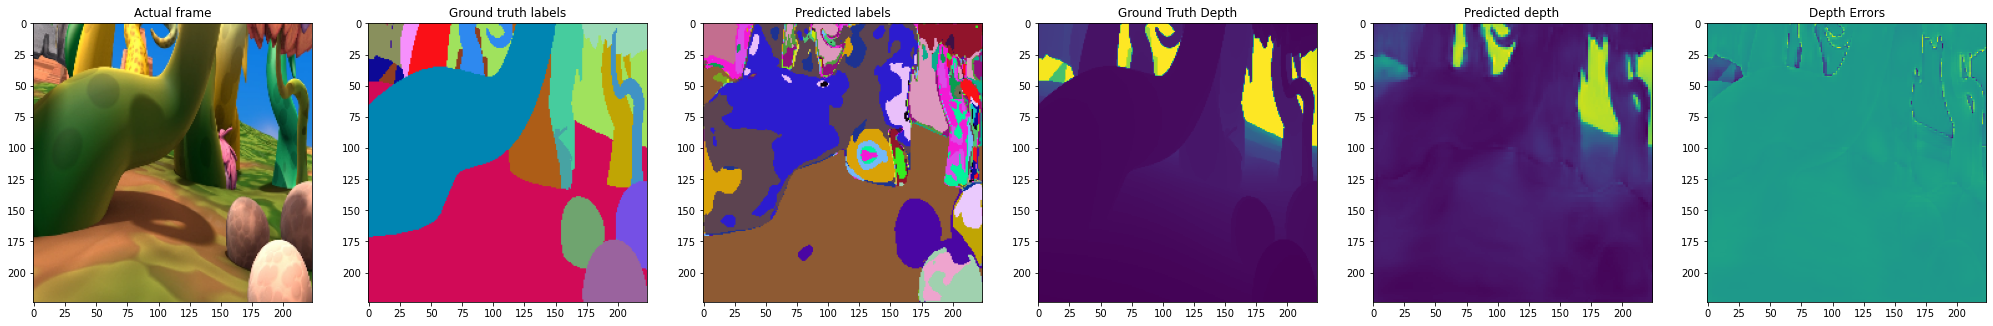

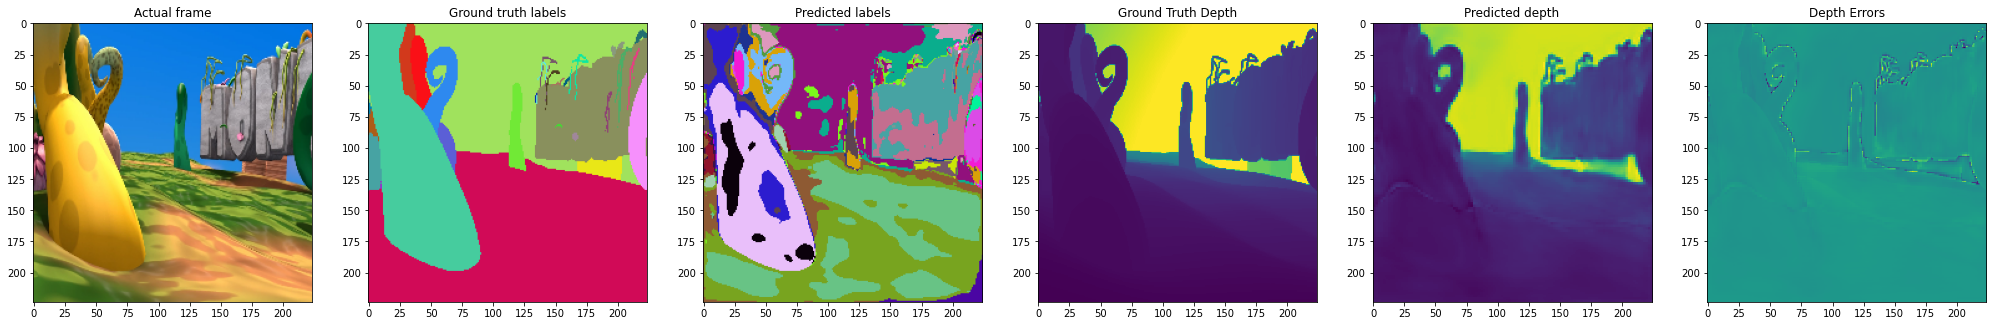

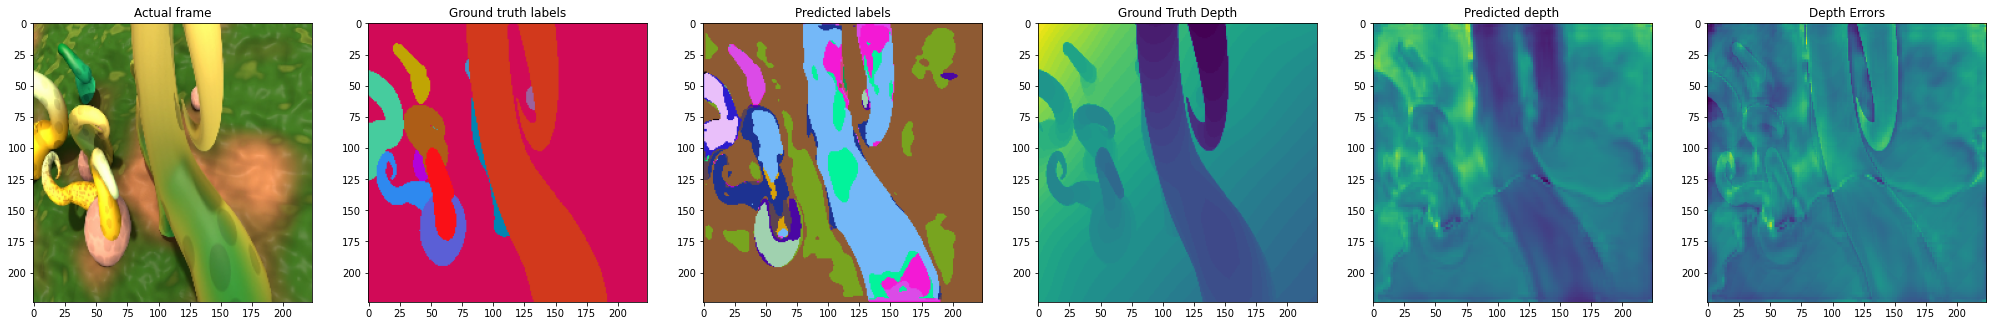

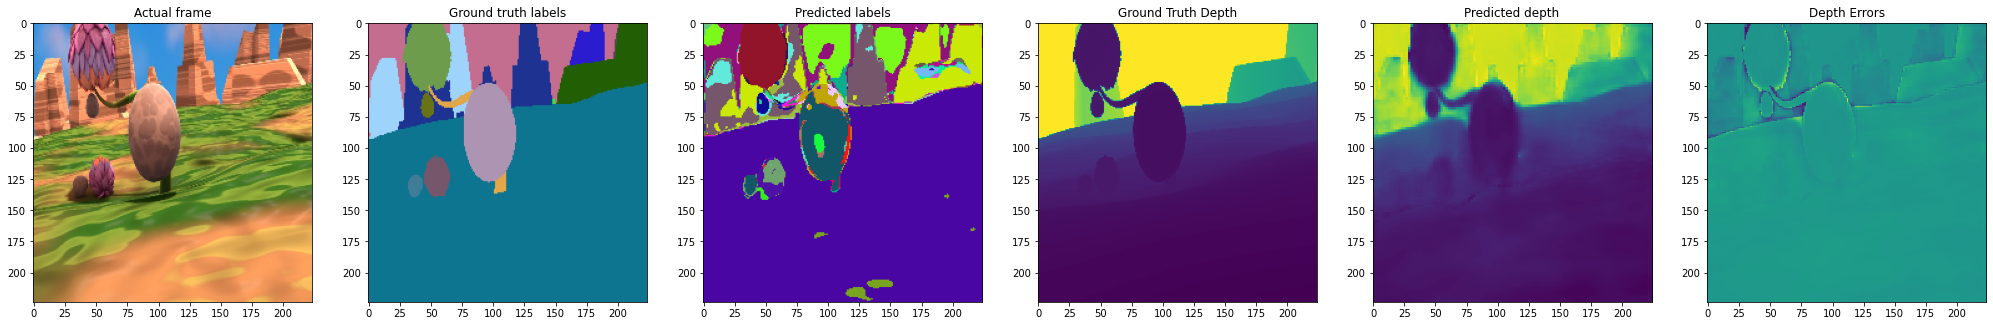

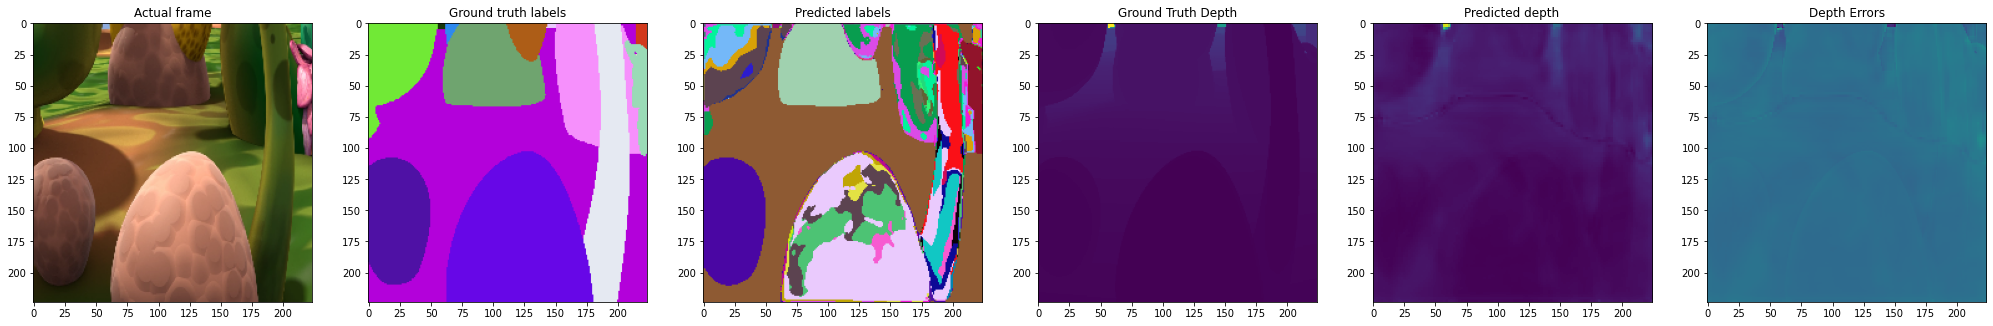

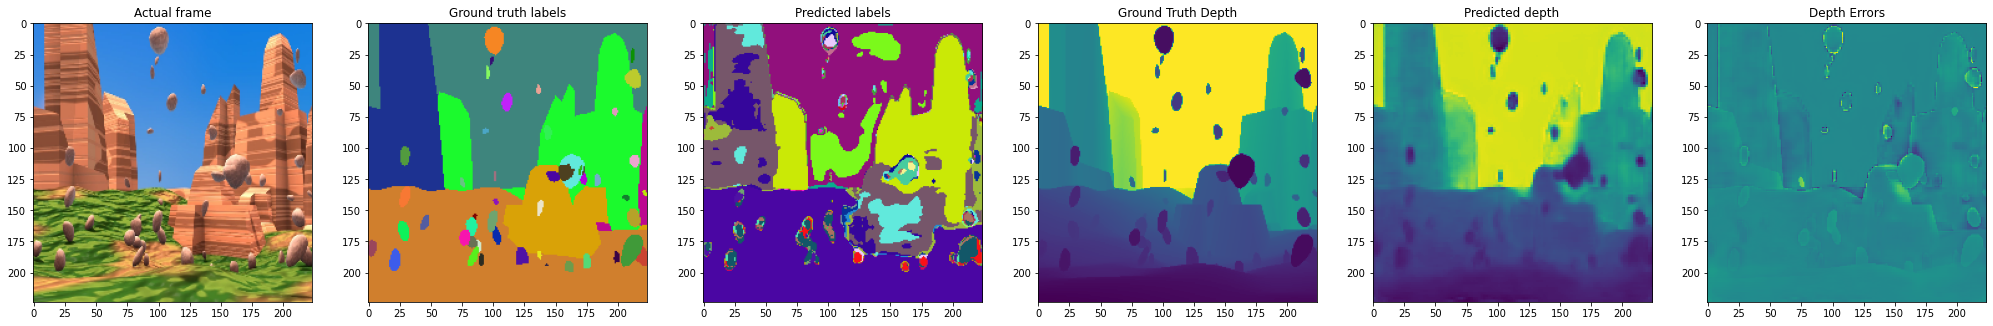

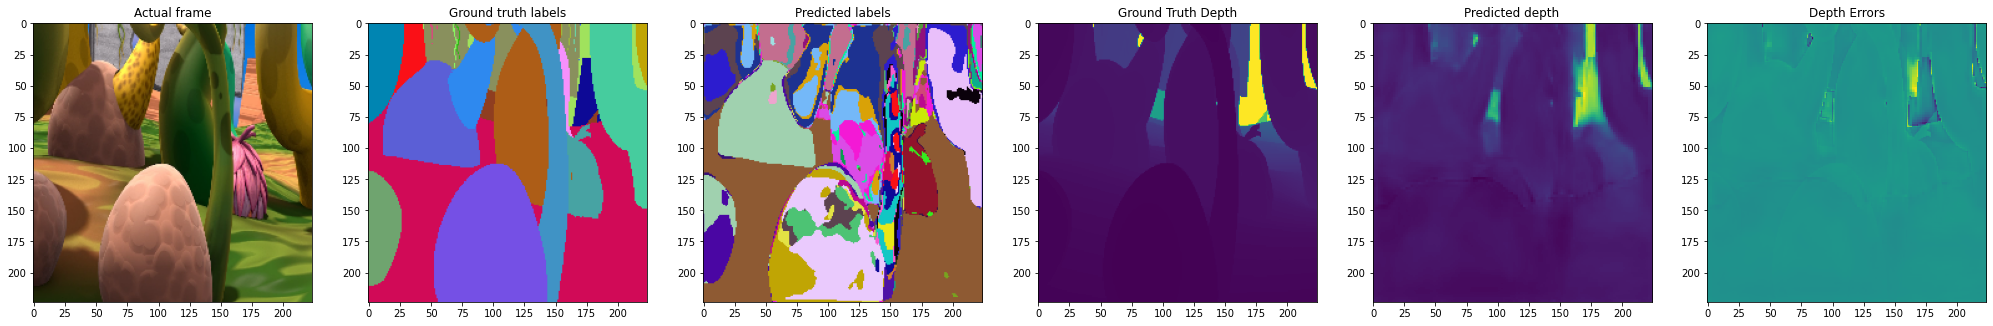

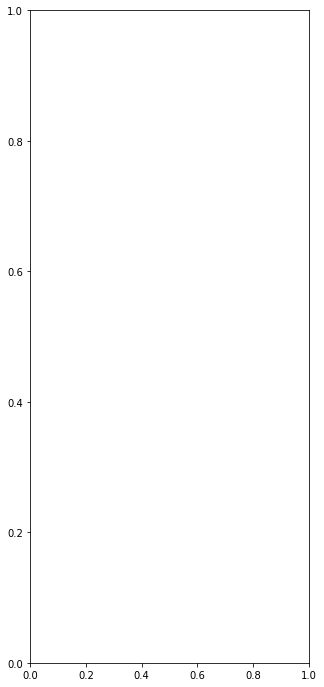

In [71]:
### p = 1
depth_errors =[]
for i in range(0,8):
    
    #print(batch_mask[i])
    fig = plt.figure(figsize=(35,12))
    
    ax1 = fig.add_subplot(1,6,1)
    ax1.imshow(left_img[i])
    ax1.title.set_text('Actual frame')
    ax1.grid(False)
    
    
    ax2 = fig.add_subplot(1,6,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(np.asarray((mask[i]))))
    ax2.grid(False)
    
    ax3 = fig.add_subplot(1,6,3)
    ax3.set_title('Predicted labels')
    ax3.imshow(onehot_to_rgb(pred_all[0][i]))
    ax3.grid(False)
   
    
    
#     TP = sum(onehot_to_rgb(pred_all[1][i]) == onehot_to_rgb(mask2[i])) 
#     TN = sum(onehot_to_rgb(pred_all[1][i]) != onehot_to_rgb(mask2[i]))
#     total = TP + TN
#     all_TP.append(TP)
#     all_TN.append(TN)
#     all_total.append(total)
#     #print(TP,TN,total)
    
    
    
    ax4 = fig.add_subplot(1,6,4)
    ax4.set_title('Ground Truth Depth')
    ax4.grid(False)
    ax4= plt.imshow(depth[i])
   
    #plt.colorbar(ax4,fraction=0.046, pad=0.04)
    
    
    ax5 = fig.add_subplot(1,6,5)
    ax5.set_title('Predicted depth')
    ax5.grid(False)
    ax5 = imshow(pred_all[2][i])
    
    #plt.colorbar(ax5,fraction=0.046, pad=0.04)
    
    
    ax6 = fig.add_subplot(1,6,6)
    ax6.set_title('Depth Errors')
    ax6 = imshow(pred_all[2][i] - depth[i])
    #set_size(35,12)
    #plt.hist(pred_all[2][i]  -depth[i])
    depth_errors.append(pred_all[2][i]-depth[i])
    
    #mappable = plt.imshow(pred_all[2][i], cmap='viridis')
   # plt.colorbar(ax6,fraction=0.046, pad=0.04)
    #plt.savefig('ChangedNewModelResultsLeft' + str(p) + '.png')
    #p =p + 1
    #plt.show()
    
#plt.saveplot('StereoSegResultsRight.png')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: FullMonkaaModel/assets


In [ ]:
def objectCheck(ground_truth,prediction):
    true_coords = []
    false_coords = []
    pred = onehot_to_rgb(prediction)
    mask = onehot_to_rgb(ground_truth)
    
    
    true_bg_coords = []
    true_app_coords = []
    true_av_coords = []
    true_muff_coords = []
    true_lem_coords = []
    true_ging_coords = []
    true_gar_coords = []
    true_carr_coords = [] 
    true_ff_coords = []
    true_ralph_coords = []
    true_corn_coords = []
    true_cour_coords = []
    true_kiwi_coords = []
    true_par_coords = []
    true_play_coords = []
    true_plum_coords = []
    true_pom_coords = []
    true_rob_coords = []
    true_roll_coords = []
    true_sco_coords = []
    true_seed_coords = []
    true_sprout_coords = []
    true_thor_coords = []
    true_tomato_coords = []
    true_corn2_coords = []
    
    false_bg_coords = []
    false_app_coords = []
    false_av_coords = []
    false_muff_coords = []
    false_lem_coords = []
    false_ging_coords = []
    false_gar_coords = []
    false_carr_coords = [] 
    false_ff_coords = []
    false_ralph_coords = []
    false_corn_coords = []
    false_cour_coords = []
    false_kiwi_coords = []
    false_par_coords = []
    false_play_coords = []
    false_plum_coords = []
    false_pom_coords = []
    false_rob_coords = []
    false_roll_coords = []
    false_sco_coords = []
    false_seed_coords = []
    false_sprout_coords = []
    false_thor_coords = []
    false_tomato_coords = []
    false_corn2_coords = []
    
    
    
    true_bg_count= 0
    true_app_count = 0
    true_av_count = 0
    true_muff_count = 0
    true_lem_count = 0
    true_ging_count = 0
    true_gar_count = 0
    true_carr_count = 0 
    true_ff_count = 0
    true_ralph_count = 0
    true_corn_count = 0
    true_cour_count = 0
    true_kiwi_count = 0
    true_par_count = 0
    true_play_count = 0
    true_plum_count = 0
    true_pom_count = 0
    true_rob_count = 0
    true_roll_count = 0
    true_sco_count = 0
    true_seed_count = 0
    true_sprout_count = 0
    true_thor_count = 0
    true_tomato_count = 0
    true_corn2_count = 0
    
    false_bg_count = 0
    false_app_count = 0
    false_av_count = 0
    false_muff_count = 0
    false_lem_count = 0
    false_ging_count = 0
    false_gar_count = 0
    false_carr_count = 0 
    false_ff_count = 0
    false_ralph_count = 0
    false_corn_count = 0
    false_cour_count = 0
    false_kiwi_count = 0
    false_par_count = 0
    false_play_count = 0
    false_plum_count = 0
    false_pom_count = 0
    false_rob_count = 0
    false_roll_count = 0
    false_sco_count = 0
    false_seed_count = 0
    false_sprout_count = 0
    false_thor_count = 0
    false_tomato_count = 0
    false_corn2_count = 0
    
    total_bg_count = 0
    total_app_count = 0
    total_av_count = 0
    total_muff_count = 0
    total_lem_count = 0
    total_ging_count = 0
    total_gar_count = 0
    total_carr_count = 0 
    total_ff_count = 0
    total_ralph_count = 0
    total_corn_count = 0
    total_cour_count = 0
    total_kiwi_count = 0
    total_par_count = 0
    total_play_count = 0
    total_plum_count = 0
    total_pom_count = 0
    total_rob_count = 0
    total_roll_count = 0
    total_sco_count = 0
    total_seed_count = 0
    total_sprout_count = 0
    total_thor_count = 0
    total_tomato_count = 0
    total_corn2_count = 0
    
    
    true_coords_list = [true_bg_coords,true_app_coords,true_av_coords,true_muff_coords,true_lem_coords,true_ging_coords,
    true_gar_coords,true_carr_coords, true_ff_coords,true_ralph_coords,true_corn_coords,true_cour_coords,true_kiwi_coords,
    true_par_coords,true_play_coords,true_plum_coords,true_pom_coords,true_rob_coords,true_roll_coords,true_sco_coords,true_seed_coords,
    true_sprout_coords,true_thor_coords,true_tomato_coords,true_corn2_coords]
    
    false_coords_list = [false_bg_coords,false_app_coords,false_av_coords,false_muff_coords,false_lem_coords,false_ging_coords,
    false_gar_coords,false_carr_coords,  false_ff_coords, false_ralph_coords, false_corn_coords, false_cour_coords, false_kiwi_coords,
    false_par_coords,false_play_coords,false_plum_coords,false_pom_coords,false_rob_coords,false_roll_coords,false_sco_coords,
    false_seed_coords,false_sprout_coords,false_thor_coords,false_tomato_coords,false_corn2_coords]
    
    
    true_count_list = [true_bg_count,true_app_count,true_av_count,true_muff_count,true_lem_count,true_ging_count,true_gar_count,
    true_carr_count, true_ff_count,true_ralph_count,true_corn_count,true_cour_count,true_kiwi_count,true_par_count,true_play_count,
    true_plum_count,true_pom_count,true_rob_count,true_roll_count,true_sco_count,true_seed_count,true_sprout_count,true_thor_count,
    true_tomato_count,true_corn2_count]
    
    
    false_count_list =  [false_bg_count,false_app_count,false_av_count, false_muff_count,false_lem_count,false_ging_count,false_gar_count,
    false_carr_count, false_ff_count,false_ralph_count,false_corn_count,false_cour_count,false_kiwi_count,false_par_count,false_play_count,
    false_plum_count,false_pom_count,false_rob_count,false_roll_count,false_sco_count,false_seed_count,false_sprout_count,false_thor_count,
    false_tomato_count,false_corn2_count]
    
    total_count_list =  [total_bg_count,total_app_count,total_av_count,total_muff_count,total_lem_count,total_ging_count,
    total_gar_count,total_carr_count,total_ff_count,total_ralph_count,total_corn_count,total_cour_count,total_kiwi_count,
    total_par_count,total_play_count,total_plum_count,total_pom_count,total_rob_count,total_roll_count,total_sco_count,
    total_seed_count,total_sprout_count,total_thor_count,total_tomato_count,total_corn2_count]
    
    
    iterate = 0
    for j in range(0,len(id2code)):
        #print('iteration:' + str(iterate))
        idx = id2code[j]
        #print(j)
        gt_coords = np.where(mask[:,:,1] == idx[1])
        pred_coords = np.where(pred[:,:,1] == idx[1])
        pred_coords = tuple(zip(pred_coords[0],pred_coords[1]))
        gt_coords = tuple(zip(gt_coords[0],gt_coords[1]))
        total_count_list[j] = len(gt_coords)
#         gt_coords_list.append(gt_coords)
#         pred_coords_list.append(pred_coords)
        for i in pred_coords:
            #print('coords:',i )
            if i in gt_coords:
                #print('true coords:', i)
                true_coords_list[j].append(i)
                true_count_list[j] += 1
                #print('pixel for class ',str(id2name[j]),' true coords found')
            if i not in gt_coords:
                #print('not in pred:',i)
                #false_coords.append(i)
                #false_count += 1
                false_coords_list[j].append(i)
                false_count_list[j] += 1
                #print('pixel for class ',str(id2name[j]),' false coords found')
        iterate +=1
            #true_count_list[j].append(true_coords)
            

    return true_coords_list,false_coords_list,true_count_list,false_count_list,total_count_list
    
    

In [ ]:
object_statistics = []

In [ ]:
for i in range(0,len(pred_all[0])):
    print('iteration: '+ str(i))
    pred = pred_all[0][i]
    masking = mask[i]
    stats = objectCheck(masking,pred)
    object_statistics.append(stats)

In [ ]:
true_counts = []
false_counts = []
total_counts = []

for i in range(len(object_statistics)):
    true_count = object_statistics[i][2]
    false_count = object_statistics[i][3]
    total_count = object_statistics[i][4]
    true_counts.append(true_count)
    false_counts.append(false_count)
    total_counts.append(total_count)

In [ ]:
print(object_statistics[0][4])

In [ ]:
rows = ['TrueBG','TrueApp','TrueAvoc','TrueMuff','TrueLem','TrueGing','TrueGar','TrueCarr','TrueFF','TrueRalph','TrueCorn',
        'TrueCourg','TrueKiwi','TruePars','TruePlay','TruePlum','TruePom','TrueRobin','TrueRoll','TrueSco','TrueSeed','TrueSprout',
       'TrueThor','TrueTom','TrueCorn2','FalseBG','FalseApp','FalseAvoc','FalseMuff','FalseLem','FalseGing','FalseGar','FalseCarr','FalseFF','FalseRalph','FalseCorn',
        'FalseCourg','FalseKiwi','FalsePars','FalsePlay','FalsePlum','FalsePom','FalseRobin','FalseRoll','FalseSco','FalseSeed','FalseSprout',
       'FalseThor','FalseTom','FalseCorn2','TotalBG','TotalApp','TotalAvoc','TotalMuff','TotalLem','TotalGing','TotalGar','TotalCarr','TotalFF','TotalRalph','TotalCorn',
        'TotalCourg','TotalKiwi','TotalPars','TotalPlay','TotalPlum','TotalPom','TotalRobin','TotalRoll','TotalSco','TotalSeed','TotalSprout',
       'TotalThor','TotalTom','TotalCorn2']

In [ ]:
csv_results = [] # Working results writer
for i in range(len(pred_all)):
    true = true_counts[i]
    false = false_counts[i]
    total = total_counts[i]
    csv_results.append(true + false + total)

In [ ]:
print(len(csv_results[0]))

In [ ]:
import csv

In [ ]:


with open("ObjectDetectionStats.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(rows)
    writer.writerows(csv_results)